# Offline learning with a loan pricing example

We'll look into off-line learning. "offline data" means that we have historical actions and rewards that were generated with a different policy. This policy might have been a random policy, a suboptimal policy or sometimes even an unknown one.

While learning from off-line data can be more challenging, it can be a good way to give your contextual bandit a warm start.

## Loan pricing example

Your task is to learn the best interest rate to offer to a customer.
There are three main components to your profits

+ Conversion rate: the probability that a customer will convert to a loan
+ Cost of risk (CoR): the cost of the risk of defaulting on the loan
+ Revenue: total income generated from the customer. This includes the amount of the loan, fees, etc.

This is a simplification, but we can write the expected profit as

$$ p(conversion) * ( revenue - CoR ) $$

In principle, the interest rate affects all three components, but in this example we'll only consider its effect on the conversion rate and cost of risk. In the `oracle` class below, you can see that each arm (interest rate) has a different effect on the conversion rate and a different cost of risk.

The context are the features of the loan and the customer. The task of the contextual bandit is to learn the best interest rate to offer to each context.

+ *Context*: In this example, we use a single feature: the credit score of the customer. The credit score goes from -5 to 5
+ *Actions / arms*: We have two actions (interest rates) to choose from: 10% and 15%



In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy.special import expit
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')


class LoanOracle:
    def __init__(self):
        self.context = None
        self.rewards = [] 
        self.optimal_rewards = [] 
        self.expected_rewards = []  # p of the article chosen for the given context

        self.true_coefs = np.array(
            [
                [1, 0.2],
                [1, 0.15]
            ]
        )
        self.cost_of_risk = np.array([0.5, 0.3])
        
        # Action 1 (interest rate 10%) doesn't have any effect on conversion rate
        # Action 2 (interest rate 15%) reduces conversion rate by 0.5
        self.conv_effect_of_interest_rate = np.array([0, -0.5])

    def set_context(self, context: NDArray[np.float64]):

        self.context = context

    def generate_reward(self, _coef: NDArray[np.float64], _cost_of_risk: float,
            _conv_effect_of_interest_rate: float) -> int:
        assert self.context is not None

        #Probability of conversion
        p_conversion = expit(np.dot(self.context, _coef) + _conv_effect_of_interest_rate)
        conversion = np.random.binomial(1, p_conversion)

        reward = conversion * (np.dot(self.context, _coef) - _cost_of_risk)
        expected_reward = p_conversion * (np.dot(self.context, _coef) - _cost_of_risk)
        self.rewards.append(reward)
        self.expected_rewards.append(expected_reward)
        return reward

    def best_expected_reward(self):
        assert self.context is not None

        p_conversions = expit(np.dot(self.context, self.true_coefs.T) + self.conv_effect_of_interest_rate)
        expected_rewards = p_conversions * (np.dot(self.context, self.true_coefs.T) - self.cost_of_risk)
        self.optimal_rewards.append(
            np.max(expected_rewards)
        )

    def interest_rate_10(self):
        """
        10% interest rate
        Works well for contexts where credit score is below ~1.3
        """
        return self.generate_reward(self.true_coefs[0], self.cost_of_risk[0], self.conv_effect_of_interest_rate[0])

    def interest_rate_15(self):
        """
        15% interest rate
        Works well for contexts where credit score is above ~2
        """
        return self.generate_reward(self.true_coefs[1], self.cost_of_risk[1], self.conv_effect_of_interest_rate[1])



### Visualizing the context and optimal action / arm

We'll construct the expected rewards for both actions over the context space (credit score of the customer from -5 to 5). We'll plot from -10 to 10, but in the simulation we'll use values between -5 and 5.

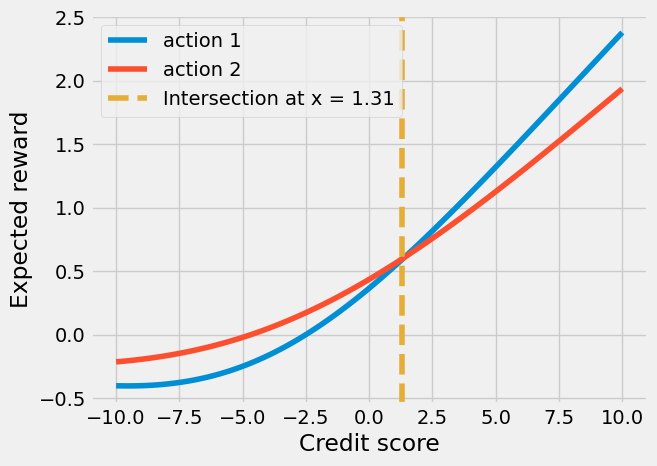

In [2]:
expected_rewards_for_action_1 = []
expected_rewards_for_action_2 = []
credit_scores = np.linspace(-10, 10, 100)
oracle = LoanOracle()

for credit_score in credit_scores:

    context = np.array([1.0, credit_score])

    p_conversion_1 = expit(np.dot(context, oracle.true_coefs[0]) 
                           + oracle.conv_effect_of_interest_rate[0])
    expected_reward_1 = p_conversion_1 * (np.dot(context, oracle.true_coefs[0]) 
                                          - oracle.cost_of_risk[0])
    expected_rewards_for_action_1.append(expected_reward_1)


    p_conversion_2 = expit(np.dot(context, oracle.true_coefs[1]) 
                           + oracle.conv_effect_of_interest_rate[1])
    expected_reward_2 = p_conversion_2 * (np.dot(context, oracle.true_coefs[1]) 
                                          - oracle.cost_of_risk[1])
    expected_rewards_for_action_2.append(expected_reward_2)

#Find intersection point where action 1 becomes better than action 2
diff = np.array(expected_rewards_for_action_1) - np.array(expected_rewards_for_action_2)
intersection_idx = np.where(np.diff(np.signbit(diff)))[0][0]

action_intersect = float(credit_scores[intersection_idx])

plt.plot(credit_scores, expected_rewards_for_action_1, label="action 1")
plt.plot(credit_scores, expected_rewards_for_action_2, label="action 2")
plt.xlabel("Credit score")
plt.ylabel("Expected reward")
plt.axvline(x=action_intersect, linestyle='--', color='#e5ae38', label=f"Intersection at x = {action_intersect:.2f}")
plt.legend()



In [3]:
from enum import Enum

class InterestRate(Enum):
    interest_rate_10 = 1
    interest_rate_15 = 2

    def take_action(self, oracle: LoanOracle):
        if self == InterestRate.interest_rate_10:
            return oracle.interest_rate_10()
        elif self == InterestRate.interest_rate_15:
            return oracle.interest_rate_15()
        else:
            raise ValueError("invalid param")


### Using online data

First we'll use online data (i.e., we will start with a weak prior and learn / update while we are taking actions).

We set up a `ContextualAgent` with a `UpperConfidenceBound` policy and a `NormalInverseGammaRegressor` learner and two arms.


In the simulation, besides the regret, we'll also record the context and the actions taken to plot them later.

Where does `true_reward_mean = 0.45`come from? It's better if the reward update is centered in 0 because of how `NormalInverseGammaRegressor()` builds its prior. In real life, we wouldn't know what this true reward mean is in advance, but we can simulate and get a number that is at least within the right scale.


In [4]:
from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    ContextualAgent,
    UpperConfidenceBound
)

arms = [
    Arm(InterestRate.interest_rate_10, learner=NormalInverseGammaRegressor()),
    Arm(InterestRate.interest_rate_15, learner=NormalInverseGammaRegressor()),
]

agent = ContextualAgent(
    arms=arms,
    policy=UpperConfidenceBound(0.96),
)

# Simulation starts
####################

oracle = LoanOracle()

np.random.seed(111)
true_reward_mean = 0.45

user_credit_scores = []
actions = []

for _ in range(3000):

    # user_credit_score is a float between -5 and 5
    user_credit_score = np.random.uniform(-5, 5) 

    context = np.array([1.0, user_credit_score])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    agent.update(context, oracle.rewards[-1] - true_reward_mean)

    user_credit_scores.append(user_credit_score)
    actions.append(action.name)




The cumulative regret is sublinear on most simulation runs. Bear in mind that we are approximating a highly non-linear function (the true data generating process of the expected reward) with a linear one (the linear model that LinUCB uses through our `NormalInverseGammaRegressor` learners).



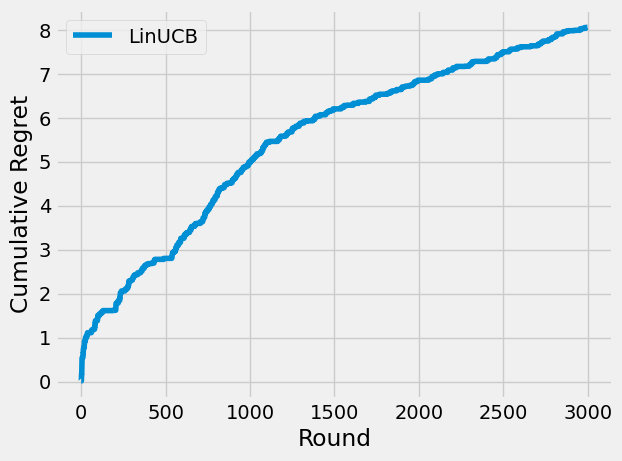

In [5]:
linucb_regret = np.cumsum(
    np.array(oracle.optimal_rewards) - np.array(oracle.expected_rewards)
)
linucb_regret_at_1000 = linucb_regret[1000]
plt.plot(linucb_regret, label="LinUCB")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

plt.legend()

Above, we found an intersection where the interest rate 10% becomes better than the 15% interest rate. If the bandit learnt correctly, we should see this interest rate more often after the intersection.

The plot below shows this is the case. This is particularly interesting since we are using a linear model to approximate a highly non-linear data generating process.


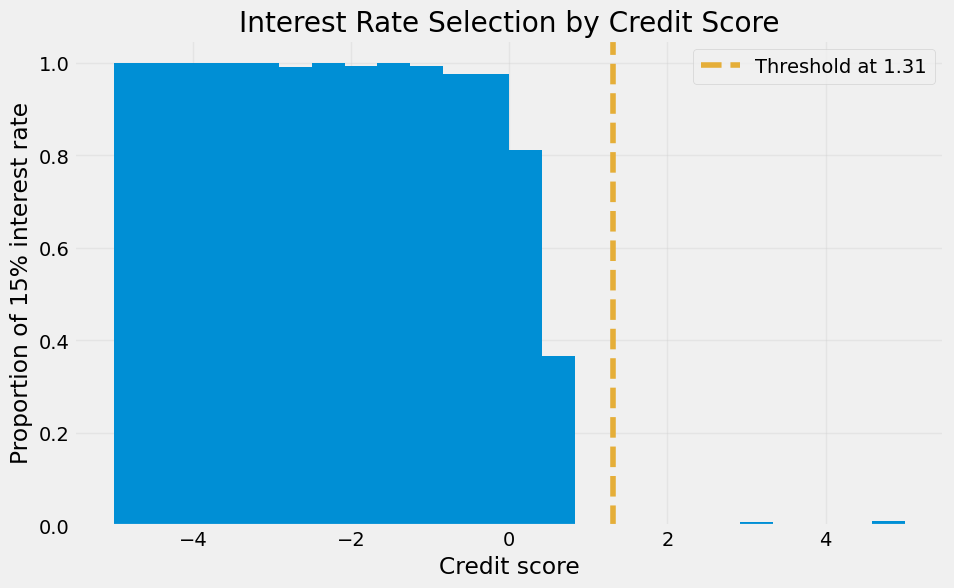

In [6]:
action_binary = np.array([1 if a == 'interest_rate_15' else 0 for a in actions])

bin_edges = np.linspace(-5, 5, 25)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate proportion of 1s for each bin
proportions = []
for i in range(len(bin_edges) - 1):
    mask = (user_credit_scores >= bin_edges[i]) & (user_credit_scores < bin_edges[i+1])
    bin_values = action_binary[mask]
    proportion = np.mean(bin_values) if len(bin_values) > 0 else 0
    proportions.append(proportion)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, proportions, width=np.diff(bin_edges)[0])
plt.axvline(x=action_intersect, linestyle='--', color='#e5ae38', 
            label=f'Threshold at {action_intersect:.2f}')
plt.xlabel('Credit score')
plt.ylabel('Proportion of 15% interest rate')
plt.title('Interest Rate Selection by Credit Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Note that we are using the actions from t = 0. If you plot the actions from, say, t = 1000 onwards, you'd see that the histogram would have a sharp cut at the threshold. In other words, the agent has learnt the best action to take for each context and barely makes mistakes (or explores) after that.

### Offline learning with a random uniform policy

We'll first simulate offline data. We'll use a random uniform policy which shouldn't give us bias. For a different policy, if you want an unbiased estimate, you should use some technique that corrects it, such as inverse propensity scoring, doubly robust estimation, etc.

We will save the actions and contexts. We can get the rewards later from the oracle. There won't be any agent updates, since we're not doing online learning.


We'll write a `simulate_offline_data` function that takes a `policy` as an object to make it clear that this "off-line" data is always created by some sort of policy, even if it's one unrelated to the contextual bandit we'll use online. 

In [7]:
def simulate_offline_data(oracle, time_periods, policy):

    contexts = []
    actions = []

    for _ in range(time_periods):

        user_credit_score = np.random.uniform(-5, 5) 

        context = np.array([1.0, user_credit_score])

        oracle.set_context(context)
        oracle.best_expected_reward()

        action = policy()
        action.take_action(oracle)

        contexts.append(context)
        actions.append(action)

    return contexts, actions

def plot_cumulative_regret(regret, title, comparison_regret=linucb_regret_at_1000):
    plt.plot(regret)
    plt.xlabel("Round")
    plt.ylabel("Cumulative Regret")
    plt.title(title)
    plt.axhline(y=comparison_regret, linestyle='--', color='#e5ae38', 
                label=f'LinUCB at 1000 rounds')
    plt.legend()
    

oracle = LoanOracle()

def random_uniform_policy():
    return InterestRate(np.random.randint(1, 3))

np.random.seed(111)
contexts, actions = simulate_offline_data(oracle, 3000, random_uniform_policy)


Now that we have the rewards, contexts and actions, we can update our agent offline. We'll use a decay rate of 0.95 to ensure that the learners don't converge too quickly and keep learning when the online data starts.

We'll write a `create_agent` function just to save a few lines of code later.

In [8]:
def create_agent(alpha=0.96):

    arms = [
        Arm(InterestRate.interest_rate_10, learner=NormalInverseGammaRegressor()),
        Arm(InterestRate.interest_rate_15, learner=NormalInverseGammaRegressor()),
    ]

    return ContextualAgent(
        arms=arms,
        policy=UpperConfidenceBound(alpha),
    )


offline_agent = create_agent()

np.random.seed(100)
# Learn from offline data
for token, reward, context in zip(actions, oracle.rewards, contexts):
    offline_agent.select_for_update(token).update(
        np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
    )

    offline_agent.decay(context, decay_rate=0.95)


Finally let's run the agent with new data and see how it performs. Will the offline learning help it converge faster?

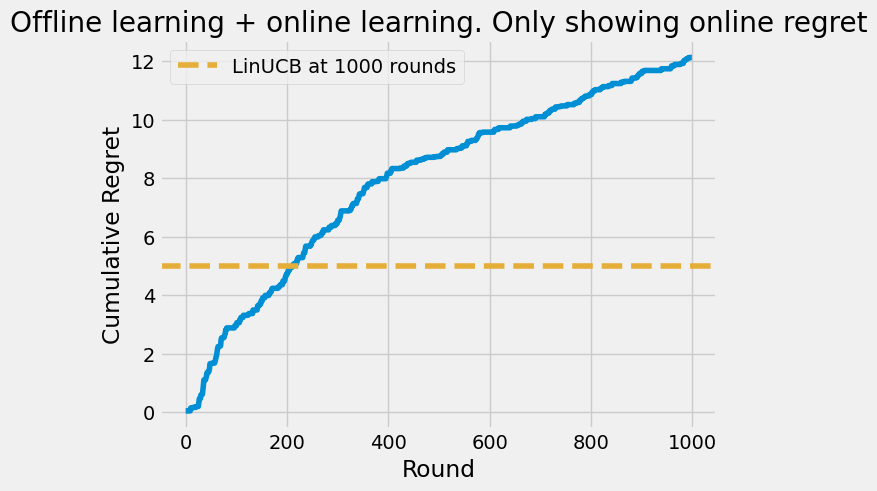

In [9]:
online_rounds = 1000
for _ in range(online_rounds):

    user_credit_score = np.random.uniform(-5, 5) 

    context = np.array([1.0, user_credit_score])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = offline_agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    offline_agent.update(context, oracle.rewards[-1] - true_reward_mean)


offline_plus_online_regret = np.cumsum(
    np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
)

plot_cumulative_regret(offline_plus_online_regret, title="Offline learning + online learning. Only showing online regret")


The cumulative regret of the offline learning + online learning is better than the regret of the online learning alone after 1000 rounds.
However, this could be worse if we choose the wrong decay rate or if the offline data is not representative of the online data.

### Offline learning with a biased policy

Now let's see if we generate data with a policy that chooses action 1 (interest rate 10%) with 80% probability and action 2 (interest rate 15%)  with 20% probability. In principle, this data will come with a bias that might harm the learning process, but we'll see how much.

We'll run the same steps as before:

1. Simulate offline data
2. Learn from offline data
3. Run online learning



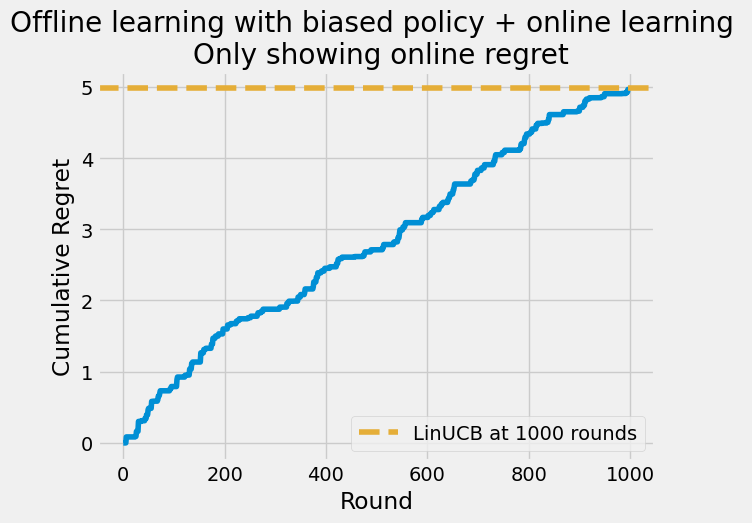

In [10]:
# 1 Simulate offline data
np.random.seed(110)
oracle = LoanOracle()

def action_1_more_likely_policy():
    return InterestRate(1) if np.random.uniform() < 0.8 else InterestRate(2)

contexts, actions = simulate_offline_data(oracle, 3000, action_1_more_likely_policy)

# 2. Learn from offline data
offline_agent = create_agent()

for token, reward, context in zip(actions, oracle.rewards, contexts):
    offline_agent.select_for_update(token).update(
        np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
    )

    offline_agent.decay(context, decay_rate=0.95)

# 3 Run online learning
online_rounds = 1000
for _ in range(online_rounds):

    user_credit_score = np.random.uniform(-5, 5) 

    context = np.array([1.0, user_credit_score])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = offline_agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    offline_agent.update(context, oracle.rewards[-1] - true_reward_mean)


offline_plus_online_regret = np.cumsum(
    np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
)

plot_cumulative_regret(offline_plus_online_regret,
                        title="Offline learning with biased policy + online learning \n Only showing online regret")


The offline learning with a biased policy did worse than the LinUCB agent without any warm start from offline data.
Can we still use the offline data but somehow correct for the bias?

One way to do this is to use inverse propensity scoring (IPS). Other technique is [doubly robust estimation](https://arxiv.org/pdf/1503.02834.pdf).

We won't be doing IPS here, but we'll use its intuition to use a different decay rate depending on the action taken. Because action one was used 4 times more than action two, we will use a higher decay rate for action 1 and a lower one for action 2. In this case, we'll use a decay rate of 0.97 for action 1 and 0.99 for action 2 (remember that a value of 0.9 gives a HIGHER decay than 0.95, in the sense that we're letting the learning decay faster)


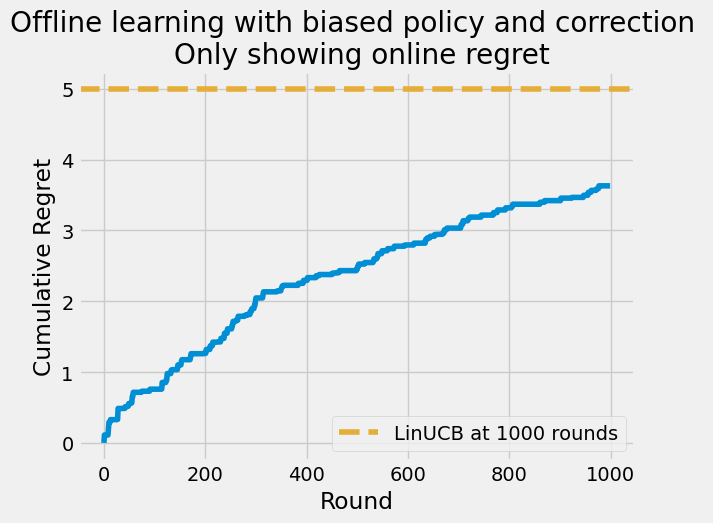

In [11]:
# 1. Simulate offline data
np.random.seed(111)
oracle = LoanOracle()

contexts, actions = simulate_offline_data(oracle, 3000, action_1_more_likely_policy)

# 2. Learn from offline data
offline_agent = create_agent()
decay_for_action_1 = 0.97 
decay_for_action_2 = 0.99

for token, reward, context in zip(actions, oracle.rewards, contexts):
    offline_agent.select_for_update(token).update(
        np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
    )
    if token == InterestRate.interest_rate_10:
        offline_agent.decay(context, decay_rate=decay_for_action_1)
    else:
        offline_agent.decay(context, decay_rate=decay_for_action_2)

# 3 Run online learning
online_rounds = 1000
for _ in range(online_rounds):

    user_age = np.random.uniform(-5, 5) 
    context = np.array([1.0, user_age])

    oracle.set_context(context)
    oracle.best_expected_reward()

    action, = offline_agent.pull(np.atleast_2d(context))
    action.take_action(oracle)
    offline_agent.update(context, oracle.rewards[-1] - true_reward_mean)


offline_plus_online_regret = np.cumsum(
    np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
)

plot_cumulative_regret(offline_plus_online_regret, title="Offline learning with biased policy and correction \n Only showing online regret")


This higher decay for the more likely action seems to have helped the offline learning.
Do note that these runs have a high variance, so the results might not be representative. We'll run the experiment multiple times to get a better idea.

# Conclusion: run the experiment multiple times

To finish off, we'll run the experiment multiple times and see the median performance. You don't need to run the rest of this code (it might a few minutes), but we'll leave it here for reference. I'll write four functions to run the experiment with different policies:

1. LinUCB just online learning: `run_linucb_online_learning`
2. Offline learning with uniform policy: `run_offline_learning_with_uniform_policy`
3. Offline learning with biased policy and no correction: `run_offline_learning_with_biased_policy_no_correction`
4. Offline learning with biased policy and correction: `run_offline_learning_with_biased_policy_and_correction`


In [12]:
REPETITIONS = 70

# 1. LinUCB just online learning
def run_linucb_online_learning(repetitions, time_periods=3000):
    np.random.seed(111)

    regrets = np.zeros((repetitions, time_periods), dtype=np.float64)

    for rep in range(repetitions):
        oracle = LoanOracle()
        agent = create_agent()

        for _ in range(time_periods):

            user_credit_score = np.random.uniform(-5, 5) 

            context = np.array([1.0, user_credit_score])

            oracle.set_context(context)
            oracle.best_expected_reward()

            action, = agent.pull(np.atleast_2d(context))
            action.take_action(oracle)
            agent.update(context, oracle.rewards[-1] - true_reward_mean)

        regrets[rep, :] = np.cumsum(
            np.array(oracle.optimal_rewards) - np.array(oracle.expected_rewards)
        )

    return regrets

#2. Offline learning with uniform policy
def run_offline_learning_with_uniform_policy(repetitions, offline_time_periods=3000, decay_rate=0.95, online_time_periods=1000):

    online_regrets = np.zeros((repetitions, online_time_periods), dtype=np.float64)
    def uniform_policy():
        return InterestRate(1) if np.random.uniform() < 0.5 else InterestRate(2)
    
    np.random.seed(111)
    for rep in range(repetitions):
        # 1 Simulate offline data
   
        oracle = LoanOracle()
        contexts, actions = simulate_offline_data(oracle, offline_time_periods, uniform_policy)

        # 2. Learn from offline data
        offline_agent = create_agent()

        for token, reward, context in zip(actions, oracle.rewards, contexts):
            offline_agent.select_for_update(token).update(
                np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
            )

            offline_agent.decay(context, decay_rate=decay_rate)

        # 3 Run online learning
        for _ in range(online_time_periods):

            user_credit_score = np.random.uniform(-5, 5) 

            context = np.array([1.0, user_credit_score])

            oracle.set_context(context)
            oracle.best_expected_reward()

            action, = offline_agent.pull(np.atleast_2d(context))
            action.take_action(oracle)
            offline_agent.update(context, oracle.rewards[-1] - true_reward_mean)


        online_regrets[rep, :] = np.cumsum(
            np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
        )

    return online_regrets

# 3. Offline learning with biased policy and no correction (same decay rate for both actions)
def run_offline_learning_with_biased_policy_no_correction(repetitions, offline_time_periods=3000,
                                                           decay_rate=0.95, online_time_periods=1000,
                                                           prob_of_action_1=0.8):

    online_regrets = np.zeros((repetitions, online_time_periods), dtype=np.float64)
    def biased_policy():
        return InterestRate(1) if np.random.uniform() < prob_of_action_1 else InterestRate(2)
    
    np.random.seed(111)
    for rep in range(repetitions):
        # 1 Simulate offline data
   
        oracle = LoanOracle()
        contexts, actions = simulate_offline_data(oracle, offline_time_periods, biased_policy)

        # 2. Learn from offline data
        offline_agent = create_agent()

        for token, reward, context in zip(actions, oracle.rewards, contexts):
            offline_agent.select_for_update(token).update(
                np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
            )

            offline_agent.decay(context, decay_rate=decay_rate)

        # 3 Run online learning
        for _ in range(online_time_periods):

            user_credit_score = np.random.uniform(-5, 5) 

            context = np.array([1.0, user_credit_score])

            oracle.set_context(context)
            oracle.best_expected_reward()

            action, = offline_agent.pull(np.atleast_2d(context))
            action.take_action(oracle)
            offline_agent.update(context, oracle.rewards[-1] - true_reward_mean)


        online_regrets[rep, :] = np.cumsum(
            np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
        )

    return online_regrets


# 4. Offline learning with biased policy and correction (different decay rates for both actions)
def run_offline_learning_with_biased_policy_and_correction(repetitions, offline_time_periods=3000,
                                                            decay_rates=[0.97, 0.995], online_time_periods=1000,
                                                            prob_of_action_1=0.8):

    online_regrets = np.zeros((repetitions, online_time_periods), dtype=np.float64)
    
    def biased_policy():
        return InterestRate(1) if np.random.uniform() < prob_of_action_1 else InterestRate(2)
    
    np.random.seed(111)
    for rep in range(repetitions):
        # 1 Simulate offline data
   
        oracle = LoanOracle()
        contexts, actions = simulate_offline_data(oracle, offline_time_periods, biased_policy)

        # 2. Learn from offline data
        offline_agent = create_agent()

        for token, reward, context in zip(actions, oracle.rewards, contexts):
            offline_agent.select_for_update(token).update(
                np.atleast_2d(context), np.atleast_1d(reward - true_reward_mean)
            )
            if token == InterestRate.interest_rate_10:
                offline_agent.decay(context, decay_rate=decay_rates[0])
            else:
                offline_agent.decay(context, decay_rate=decay_rates[1])

        # 3 Run online learning
        for _ in range(online_time_periods):

            user_credit_score = np.random.uniform(-5, 5) 

            context = np.array([1.0, user_credit_score])

            oracle.set_context(context)
            oracle.best_expected_reward()

            action, = offline_agent.pull(np.atleast_2d(context))
            action.take_action(oracle)
            offline_agent.update(context, oracle.rewards[-1] - true_reward_mean)


        online_regrets[rep, :] = np.cumsum(
            np.array(oracle.optimal_rewards[-online_rounds:]) - np.array(oracle.expected_rewards[-online_rounds:])
        )

    return online_regrets

Now we run these four functions and plot the results. We'll use the median values (over the repetitions) of the cumulative regret per time period.

*Note: We suppress warnings about divide by zero and invalid values that arise in a few simulation runs just to keep the output clean*

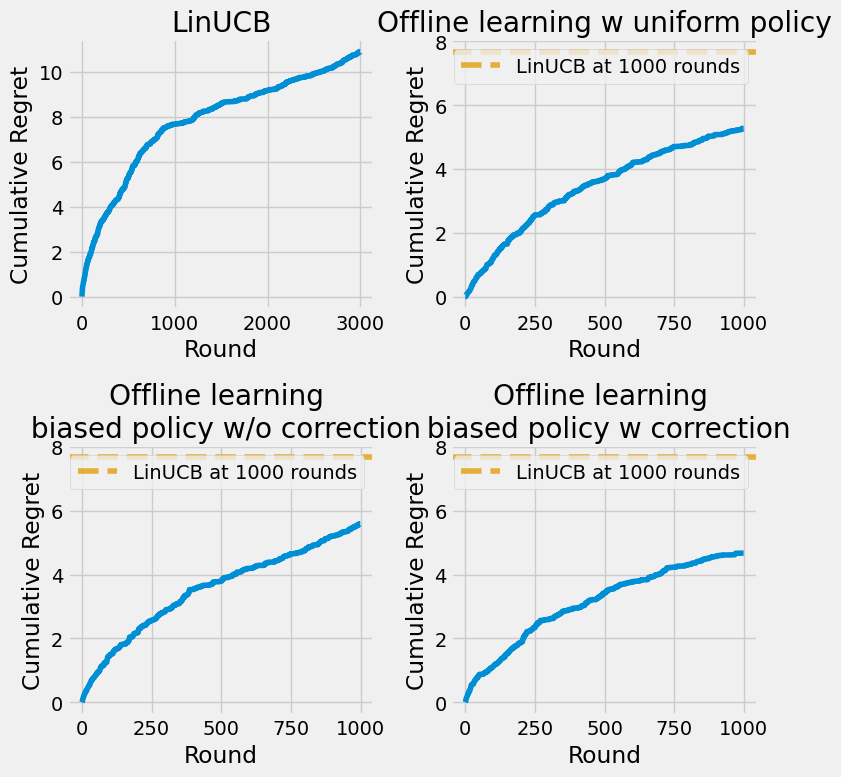

In [13]:
import warnings

#Supress divide by zero and invalid value warnings
def custom_warning_filter(message, category, filename, lineno, file=None, line=None):
    if category == RuntimeWarning:
        if "divide by zero" in str(message) or "invalid value" in str(message):
            return None  
    return True  

warnings.showwarning = custom_warning_filter


linucb_regrets = run_linucb_online_learning(REPETITIONS)
offline_uniform_policy_regrets = run_offline_learning_with_uniform_policy(REPETITIONS)

biased_policy_no_correction_regrets = run_offline_learning_with_biased_policy_no_correction(REPETITIONS,
                                                                                            prob_of_action_1=0.9)
biased_policy_with_correction_regrets = run_offline_learning_with_biased_policy_and_correction(REPETITIONS,
                                                                                               prob_of_action_1=0.9,
                                                                                               decay_rates=[0.97, 0.995])

# Plot the 4 median regrets in one figure
# ####################################3    
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# LinUCB
linucb_median_regret = np.median(linucb_regrets, axis=0)
linucb_mean_regret_at_1000 = linucb_median_regret[1000]
axs[0, 0].plot(linucb_median_regret, label="LinUCB")
axs[0, 0].set_title("LinUCB")
axs[0, 0].set_xlabel("Round")
axs[0, 0].set_ylabel("Cumulative Regret")

# Offline learning with uniform policy
offline_uniform_policy_median_regrets = np.median(offline_uniform_policy_regrets, axis=0) 
axs[0, 1].plot(offline_uniform_policy_median_regrets)
axs[0, 1].set_title("Offline learning w uniform policy")
axs[0, 1].axhline(y=linucb_mean_regret_at_1000, linestyle='--', color='#e5ae38', 
                label=f'LinUCB at 1000 rounds')
axs[0, 1].set_xlabel("Round")
axs[0, 1].set_ylabel("Cumulative Regret")


# Offline learning with biased policy no correction
biased_policy_no_correction_median_regrets = np.median(biased_policy_no_correction_regrets, axis=0)
axs[1, 0].plot(biased_policy_no_correction_median_regrets)
axs[1, 0].set_title("Offline learning \n biased policy w/o correction")
axs[1, 0].axhline(y=linucb_mean_regret_at_1000, linestyle='--', color='#e5ae38', 
                label=f'LinUCB at 1000 rounds')
axs[1, 0].set_xlabel("Round")
axs[1, 0].set_ylabel("Cumulative Regret")

# Offline learning with biased policy with correction
biased_policy_with_correction_median_regrets = np.median(biased_policy_with_correction_regrets, axis=0) 
axs[1, 1].plot(biased_policy_with_correction_median_regrets)
axs[1, 1].set_title("Offline learning \n biased policy w correction")
axs[1, 1].axhline(y=linucb_mean_regret_at_1000, linestyle='--', color='#e5ae38', 
                label=f'LinUCB at 1000 rounds')
axs[1, 1].set_xlabel("Round")
axs[1, 1].set_ylabel("Cumulative Regret")

for ax in [axs[0, 1], axs[1, 0], axs[1, 1]]:
    ax.legend()

plt.tight_layout()


## Bonus: Optimize the decay rates with optuna

We'll leave this code commented out, but you can run it to optimize the decay rates.

In [14]:
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial: optuna.Trial):
#     #np.random.seed(3)
#     decay_rate_action_1 = trial.suggest_float("decay_rate_action_1", 0.80, 0.97)
#     decay_rate_action_2 = trial.suggest_float("decay_rate_action_2", 0.94, 1.0)
#     REPETITIONS = 30
#     biased_policy_with_correction_regrets = run_offline_learning_with_biased_policy_and_correction(REPETITIONS,
#                                                                                                prob_of_action_1=0.9,
#                                                                                                decay_rates=[decay_rate_action_1, decay_rate_action_2])
#     regret_ten_last_periods_avg = biased_policy_with_correction_regrets.mean(axis=0)[-10::].mean()
#     return regret_ten_last_periods_avg


#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=30)